In [47]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# Step 1: Caricare il dataframe da train.csv
df = pd.read_csv('train.csv')

# Preprocessamento dei dati
df[(df['EDUCATION'] < 1) | (df['EDUCATION'] > 4)] = 4
df[(df['MARRIAGE'] < 1) | (df['MARRIAGE'] > 3)] = 3

for pay_col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    df[df[pay_col] < 0] = 0
    df[df[pay_col] > 9] = 9

# Assicurati che la colonna "default payment next month" contenga solo valori binari
df['default payment next month'] = df['default payment next month'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else np.nan))

# Rimuovi righe con valori NaN
df.dropna(subset=['default payment next month'], inplace=True)

# Step 1.1: Definire X e y
X = df.drop(columns=['default payment next month']).values
y = df['default payment next month'].values

# Step 1.2: Suddividere il dataset in training e validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizzare i dati di input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 2: Definire l'architettura della rete neurale
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Primo livello
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Aumenta il dropout

    # Secondo livello
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Aumenta il dropout

    # Terzo livello
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Aumenta il dropout

    # Quarto livello
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Aumenta il dropout

    # Livello di output
    model.add(Dense(1, activation='sigmoid'))

    # Compilare il modello
    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Abbassato il learning rate
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

# Step 3: Costruire il modello
input_shape = X_train_scaled.shape[1]
model = build_model(input_shape)

# Step 4: Definire i parametri di addestramento
batch_size = 64
epochs = 300

# Step 5: Early stopping e learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model.summary()

# Step 6: Addestrare il modello
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr])

# Step 7: Valutare il modello sul set di validazione
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Step 8: Calcolare e stampare l'F1 Score
y_pred_prob = model.predict(X_val_scaled)  
y_pred = (y_pred_prob > 0.5).astype(int)  

# Calcola l'F1 score
f1 = f1_score(y_val, y_pred, average='macro')  
print(f"F1 Score: {f1}")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,017 (54.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6130 - loss: 1.2442 - val_accuracy: 0.8780 - val_loss: 0.8363 - learning_rate: 5.0000e-04
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7977 - loss: 0.9422 - val_accuracy: 0.8900 - val_loss: 0.7557 - learning_rate: 5.0000e-04
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8542 - loss: 0.8255 - val_accuracy: 0.8925 - val_loss: 0.6985 - learning_rate: 5.0000e-04
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8631 - loss: 0.7563 - val_accuracy: 0.8933 - val_loss: 0.6462 - learning_rate: 5.0000e-04
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8747 - loss: 0.6996 - val_accuracy: 0.8931 - val_loss: 0.6125 - learning_rate: 5.0000e-04
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8831 - loss: 0.6512 - val_accuracy: 0.8945 - val_loss: 0.5779 - learning_rate: 5.0000e-04
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - ac

In [48]:
# Step 9: Importare il dataframe da test.csv e fare il clipping
test_df = pd.read_csv('test.csv')

# Clipping dei dati
test_df[(test_df['EDUCATION'] < 1) | (test_df['EDUCATION'] > 4)] = 4
test_df[(test_df['MARRIAGE'] < 1) | (test_df['MARRIAGE'] > 3)] = 3

for pay_col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    test_df[test_df[pay_col] < 0] = 0
    test_df[test_df[pay_col] > 9] = 9

# Step 10: Preparare i dati di test
X_test = test_df.values  # Assicurati di rimuovere la colonna target se presente
X_test_scaled = scaler.transform(X_test)

# Step 11: Fare previsioni
test_predictions_prob = model.predict(X_test_scaled)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Step 12: Salvare le previsioni in test_predictions.csv
pd.DataFrame(test_predictions, columns=['Predicted']).to_csv('test_predictions.csv', index=False, header=False)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


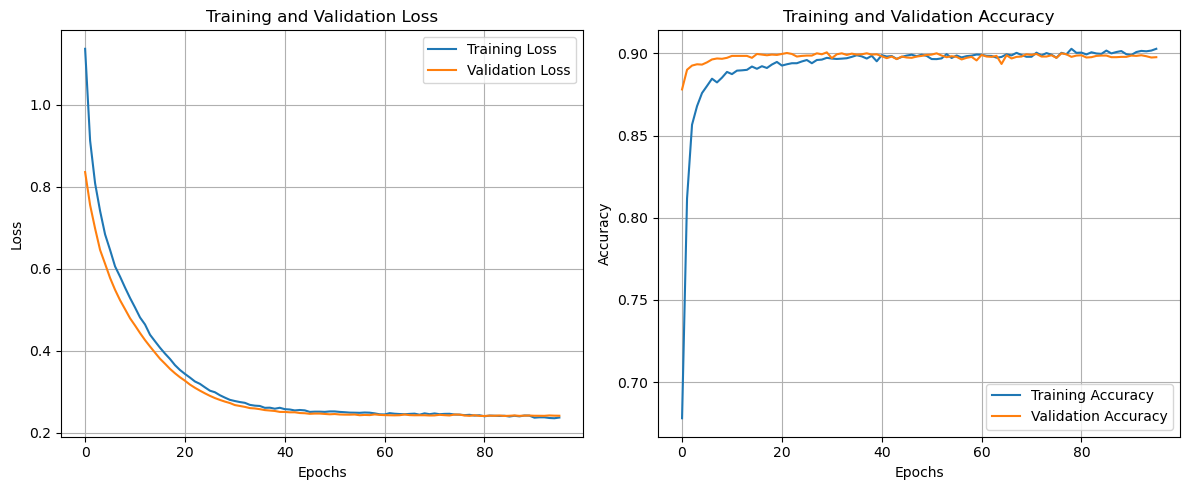

Final Training Loss: 0.2373
Final Validation Loss: 0.2417
Final Training Accuracy: 0.9027
Final Validation Accuracy: 0.8976
The model performs better on the training set compared to the validation set, which might indicate overfitting.


In [49]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy over epochs.

    Parameters
    ----------
    history: History
        Keras History object containing training metrics.
    """
    # Plotting Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Step 1: Call the plot function to visualize the training history
plot_training_history(history)

# Step 2: Analyze results
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Step 3: Initial considerations
if final_train_loss < final_val_loss:
    print("The model performs better on the training set compared to the validation set, which might indicate overfitting.")
elif final_train_loss > final_val_loss:
    print("The model performs better on the validation set compared to the training set, indicating potential underfitting.")
else:
    print("The model performs similarly on both sets, suggesting a good fit.")

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Generate predictions on the validation set
y_val_pred_prob = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Confusion Matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Step 3: Classification Report
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Step 4: Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[4134  192]
 [ 325  449]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.93      0.96      0.94      4326
     Default       0.70      0.58      0.63       774

    accuracy                           0.90      5100
   macro avg       0.81      0.77      0.79      5100
weighted avg       0.89      0.90      0.89      5100

ROC AUC Score: 0.9172


In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Funzione per caricare i dati
def load_data(url, train=True):
    data = pd.read_csv(url)
    if train:
        # Se hai colonne target, separale qui
        return data.drop('default payment next month', axis=1), data['default payment next month']
    else:
        return data, data['ID']  # Assumendo che tu abbia una colonna ID nei dati di test

# Funzione per preprocessare i dati
def preprocess_data(X, scaler=None):
    if scaler is None:
        # Creiamo un nuovo scaler se non è passato uno
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)  # Fit e transform sui dati di addestramento
    else:
        X_scaled = scaler.transform(X)  # Solo transform sui dati di test
    return X_scaled, scaler

# Funzione di clipping (da applicare sia ai dati di addestramento che a quelli di test)
def clip_data(df):
    df[(df['EDUCATION'] < 1) | (df['EDUCATION'] > 4)] = 4
    df[(df['MARRIAGE'] < 1) | (df['MARRIAGE'] > 3)] = 3

    for pay_col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
        df[df[pay_col] < 0] = 0
        df[df[pay_col] > 9] = 9

    return df

# Load the dataset
url_train = './train.csv'
url_test = './test.csv'

# Load the training data
X_train, y_train = load_data(url_train, train=True)

# Applicare il clipping sui dati di addestramento
X_train = clip_data(X_train)

# Inizializziamo lo scaler e scalariamo i dati di addestramento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Load the test data
X_test, test_ids = load_data(url_test, train=False)

# Applicare il clipping sui dati di test
X_test = clip_data(X_test)

# Assicuriamoci che X_test abbia le stesse colonne di X_train
# Opzionalmente puoi riempire o eliminare colonne mancanti
# Esempio: rimuovere colonne che non sono presenti in X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Preprocess the test data
X_test_scaled, _ = preprocess_data(X_test, scaler=scaler)

# Step 1: Make predictions on the test set
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Create a DataFrame for submission or further analysis
results = pd.DataFrame({
    'Default_Prediction': y_test_pred.flatten(),
})

# Step 3: Save predictions to a CSV file (optional)
results.to_csv('test_predictions.csv', index=False, header=False)  # header=True per includere i nomi delle colonne

# Display predictions
print("Predictions on Test Set:")
print(results.head())


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions on Test Set:
   Default_Prediction
0                   0
1                   0
2                   0
3                   0
4                   0
